In [12]:
using ModelingToolkit, Sophon, DomainSets
using Optimization, OptimizationOptimJL

@parameters t, x
@variables u(..), v(..)
Dt = Differential(t)
Dx = Differential(x)
Dxx = Differential(x)^2

r1 = 0.02f0
r2 = 1

eqs = [Dt(u(t, x)) - Dxx(r2*(u(t,x)^3 - u(t,x)) - r1 * v(t,x)),
       v(t, x) ~ Dxx(u(t,x))]

bcs = [u(0, x) ~ cospi(x)-exp(-4*1f0π*1f0π*abs2(x)),
    v(0, x) ~ Dxx(u(0,x)),
    u(t, -1) ~ u(t, 1),
    Dx(u(t, -1)) ~ Dx(u(t, 1)),
    v(t, -1) ~  Dxx(u(t, -1)),
    v(t, 1) ~ Dxx(u(t, 1))]

domains = [t ∈ Interval(0, 1),
           x ∈ Interval(-1, 1)]

@named pde_system = PDESystem(eqs, bcs, domains, [t,x], [u(t,x), v(t,x)])

PDESystem
Equations: Equation[Differential(t)(u(t, x)) ~ (3abs2(u(t, x)) - 1)*Differential(x)(Differential(x)(u(t, x))) + 6abs2(Differential(x)(u(t, x)))*u(t, x) - 0.02Differential(x)(Differential(x)(v(t, x))), v(t, x) ~ Differential(x)(Differential(x)(u(t, x)))]
Boundary Conditions: Equation[u(0, x) ~ cospi(x) - exp(-39.47842abs2(x)), v(0, x) ~ Differential(x)(Differential(x)(u(0, x))), u(t, -1) ~ u(t, 1), Differential(x)(u(t, -1)) ~ Differential(x)(u(t, 1)), v(t, -1) ~ Differential(x)(Differential(x)(u(t, -1))), v(t, 1) ~ Differential(x)(Differential(x)(u(t, 1)))]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(t, 0..1), Symbolics.VarDomainPairing(x, -1..1)]
Dependent Variables: Num[u(t, x), v(t, x)]
Independent Variables: Num[t, x]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

In [18]:
chain = FullyConnected(2, 1, tanh; hidden_dims=16, num_layers=5) |> Sophon.gpu
pinn = PINN(u=chain, v=chain)
sampler = BetaRandomSampler(1000, (400, 400, 100, 100, 100, 100))
strategy = NonAdaptiveTraining(1, (500, 500,10,10,10,10))
prob = Sophon.discretize(pde_system, pinn, sampler, strategy) 

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(u = (layer_1 = (weight = [1.2980719804763794 1.8622103929519653; 0.45888930559158325 1.0623027086257935; … ; -0.11766144633293152 -1.4849692583084106; -1.3316268920898438 -1.9928404092788696], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = [-0.05721748620271683 0.38948649168014526 … 0.5055073499679565 0.36983028054237366; 0.5709289312362671 -0.1471622735261917 … -0.5291082262992859 0.5358058214187622; … ; 0.21688975393772125 -0.6034715175628662 … -0.48217329382896423 -0.2746174931526184; -0.1009681448340416 0.7086412906646729 … -0.13869072496891022 0.122724749147892], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = [0.6595517992973328 -0.7100216150283813 … 0.1457299292087555 -0.3580392599105835; -0.1302851438522339 -0.23055186867713928 … 0.08734551072120667 0.1274522840976715; … ; -0.45568811893463135 0.3669111132621765 … 0.5093075633049011 -0.6408072113990784; 0.40955695509910583 0.1208495944738388 … -0.

In [19]:
i = 0
function callback(p, l)
    global i
    i%100==0 && println("Loss: $l")
    i += 1
    return false
end

@time res = Optimization.solve(prob, BFGS(); maxiters=1000, callback=callback)

Loss: 111317.10529804658


Loss: 124.81454240256433


Loss: 80.30267419871431


Loss: 34.05996831946904


Loss: 23.00212791692142


Loss: 14.028725138114293


Loss: 10.66694511199969


Loss: 9.054197903015389


Loss: 7.8130104773638935


Loss: 6.659047920107418


Loss: 6.130852886662223
311.947297 seconds (104.92 M allocations: 537.151 GiB, 8.17% gc time)


u: ComponentVector{Float64}(u = (layer_1 = (weight = [1.3039266871630821 6.888142360184886; 0.435998615766432 -2.3667381393053653; … ; -0.2463431104800844 -1.2801530036559348; -1.3410170034800823 -3.279887836971781], bias = [24.535685034084928; -14.862379225346645; … ; -5.2412051927900745; -12.792979105128252;;]), layer_2 = (weight = [-2.7698401233980268 -1.1720279199614803 … 2.662238540704317 3.270501158024254; -0.2990077266208203 -0.2794700751328525 … 0.21350479779795892 1.453552762520277; … ; 4.0001423754525725 1.5571803218752893 … -3.486344105674175 -4.324837938346737; -3.8839407657943377 -1.4918737844502488 … 2.8963781469786345 4.16229120295556], bias = [-7.762328226819855; -3.9974616983984093; … ; 6.32762667195784; -9.559777234202855;;]), layer_3 = (weight = [0.16748510904646832 -0.12406802564615818 … -0.376625531512066 -0.21826516210330468; 4.113902807440759 -1.4479128082653214 … 4.540948907071111 -1.0038998612049275; … ; -0.6419730276805372 0.6849425228584041 … -0.0341107232235

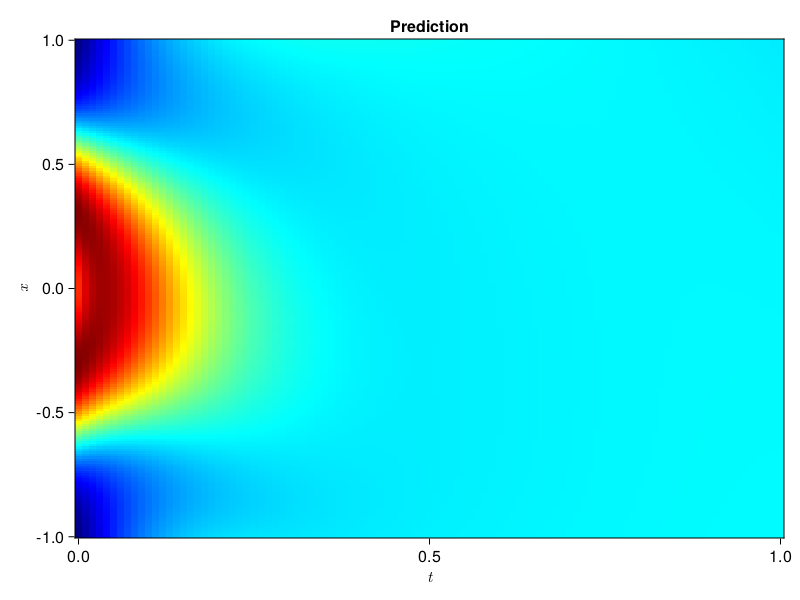

In [20]:
using CairoMakie, MakiePublication

phi = pinn.phi
ts, xs = [infimum(d.domain):0.01:supremum(d.domain) for d in pde_system.domain]
axis = (xlabel=L"t", ylabel=L"x", title="Prediction")
u_pred = [sum(pinn.phi.u([t, x], Sophon.cpu(res.u.u))) for t in ts, x in xs]
heatmap(ts, xs, u_pred, axis=axis, colormap=:jet)

In [21]:
for α in [0.6, 0.8, 1.0] 
    i = 0
    sampler = remake(sampler; α=α)
    data = Sophon.sample(pde_system, sampler)
    prob = remake(prob; p=data, u0=res.u)
    res = Optimization.solve(prob, BFGS(); maxiters=1000, callback=callback)

    u_pred = [sum(pinn.phi.u([t, x], Sophon.cpu(res.u.u))) for t in ts, x in xs]
    fig, ax, hm = heatmap(ts, xs, u_pred, axis=axis, colormap=:jet)
    display(fig)
end

Loss: 25.873222371306827


Loss: 7.557466853025001


Loss: 5.691993875761543
